In [ ]:
from utils import iteration_logging
from graph_cycle_iterator import GraphCycleIterator
from graph_edge_iterator import GraphEdgeIterator
from tqdm.auto import tqdm
import io
import pandas as pd

In [2]:

OMEGA = 30
BUFFER_COUNT = 2
PRUNE_INTERVAL = 1_000
END_DATE = "2019-08-10"



In [3]:
def edge_generator():
    return GraphEdgeIterator(end_date=END_DATE, buffer_count=BUFFER_COUNT)

def wrapped_edge_generator(log_stream):
    return tqdm(iteration_logging(edge_generator(), log_stream=log_stream), total=TOTAL_EDGES)

def cycle_generator(omega, log_stream_edges=None, track_history=False):
    return GraphCycleIterator(wrapped_edge_generator(log_stream_edges), omega, track_history=track_history)

In [4]:
TOTAL_EDGES = len(list(edge_generator()))

In [5]:
log_stream_edges = io.StringIO()
log_stream_cycles = io.StringIO()

wrapped_cycles = iteration_logging(cycle_generator(OMEGA, log_stream_edges), log_stream=log_stream_cycles)

cycles = [c for c in wrapped_cycles]


  0%|          | 0/551830 [00:00<?, ?it/s]

array([<Axes: xlabel='time_seconds'>, <Axes: xlabel='time_seconds'>,
       <Axes: xlabel='time_seconds'>, <Axes: xlabel='time_seconds'>,
       <Axes: xlabel='time_seconds'>], dtype=object)

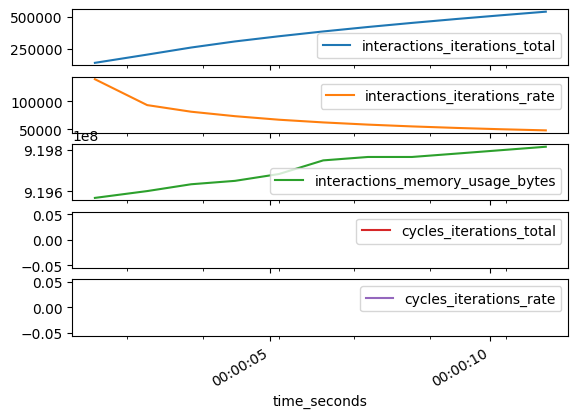

In [6]:
dfs = []
for index, (prefix, log_stream) in enumerate({
    "interactions": log_stream_edges,
    "cycles": log_stream_cycles
}.items()):
    log_stream.seek(0)
    df = pd.read_csv(log_stream)
    df["time_seconds"] = pd.to_datetime(df["time_seconds"], unit="s")
    if index > 0:
        df = df.drop(columns="memory_usage_bytes")
    df = df.set_index("time_seconds").add_prefix(prefix + "_")
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df.plot(subplots=True)

In [5]:
generator = cycle_generator(OMEGA, track_history=True)
list(generator)

  0%|          | 0/551830 [00:00<?, ?it/s]

[]

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def bin_lengths(lengths, bin_edges):
    """Bins length counts into predefined bins."""
    binned_counts = {f"{bin_edges[i]}-{bin_edges[i+1]}": 0 for i in range(len(bin_edges) - 1)}
    for length, count in lengths.items():
        for i in range(len(bin_edges) - 1):
            if bin_edges[i] <= length < bin_edges[i + 1]:
                binned_counts[f"{bin_edges[i]}-{bin_edges[i+1]}"] += count
                break
    return binned_counts

def process_data_for_plot(data):
    """Converts list of length-count dictionaries into a DataFrame for plotting."""
    all_lengths = set()
    for d in tqdm(data, "determining min/max"):
        all_lengths.update(d.keys())

    min_len, max_len = min(all_lengths), max(all_lengths)

    # Define sensible bins (logarithmic if range is large, otherwise equal-width)
    if max_len - min_len > 20:
        bin_edges = np.unique(np.logspace(np.log10(min_len), np.log10(max_len), num=10, dtype=int))
    else:
        bin_edges = np.arange(min_len, max_len + 5, step=max((max_len - min_len) // 10, 1))

    # Re-bin the data
    binned_data = [bin_lengths(d, bin_edges) for d in data]

    # Convert to DataFrame
    df = pd.DataFrame(binned_data).fillna(0)
    return df

def plot_stacked_area(df):
    """Plots a stacked area chart from the processed DataFrame."""
    df.plot(kind='area', stacked=True, colormap='viridis', alpha=0.7, figsize=(10, 6))
    plt.xlabel("Index")
    plt.ylabel("Count")
    plt.title("Stacked Area Chart of Binned Length Frequencies")
    plt.legend(title="Bins", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


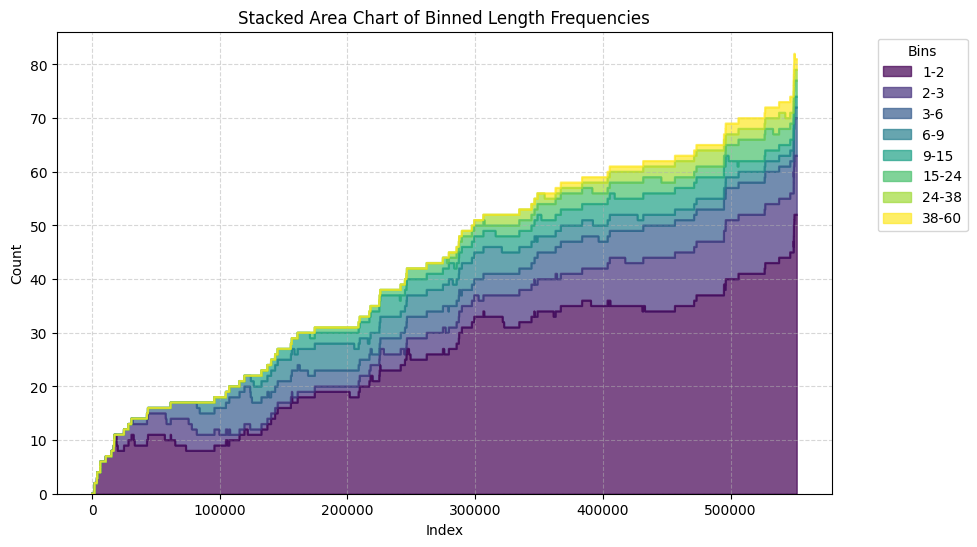

In [11]:
# Process and plot
df = process_data_for_plot(generator.separate_seeds_history)
plot_stacked_area(df)

determining min/max:   0%|          | 0/376206 [00:00<?, ?it/s]

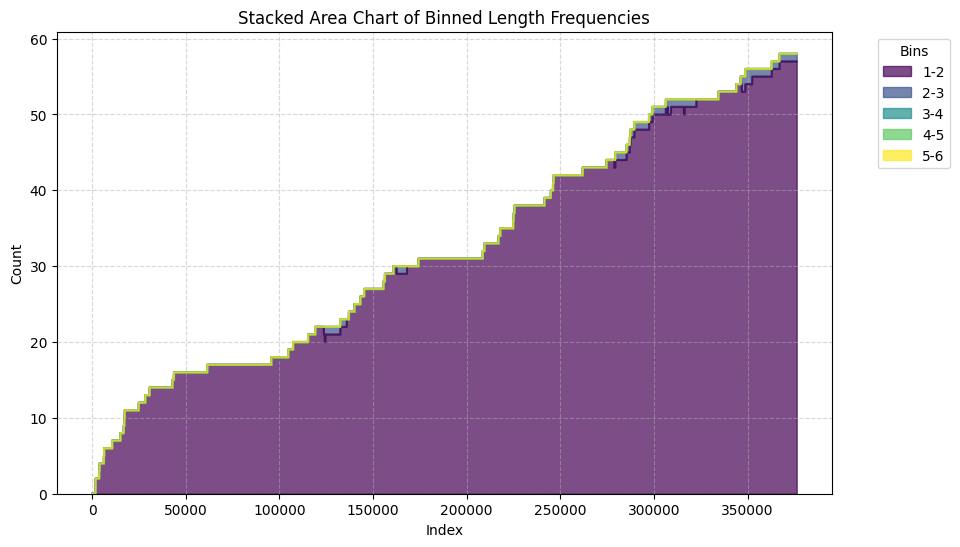

In [8]:
# Process and plot
df = process_data_for_plot(generator.combined_seeds_history)
plot_stacked_area(df)

In [5]:
minimums = list(cycle_generator(OMEGA))

  0%|          | 0/551830 [00:00<?, ?it/s]

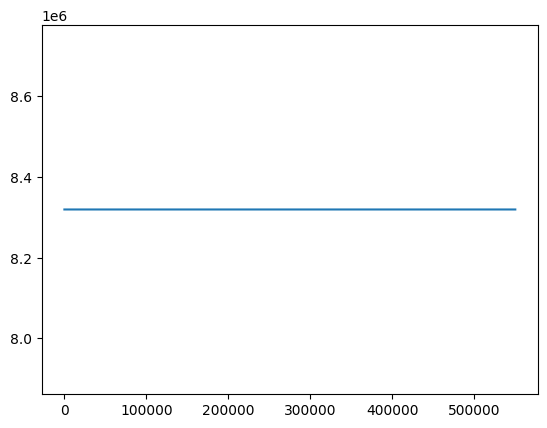

In [6]:
import matplotlib.pyplot as plt

plt.plot(minimums)